# RL model fitting to 2AFC behavioral data

This notebook demonstrates methods for fitting and comparing RL models to behavioural data from trial-by-trial decision making tasks.  The data are from subjects performing a two alternative forced choice (2AFC) probabilistic reversal learning task.  Each behavioural session consists of around 400 trials. On each trial the subject makes a choice (left or right) and recieve an outcome (rewarded or not).  25% of trial were forced choice, where only one of the two options was available for selection.  

The notebook shows methods for maximum likelihood (ML) and maximum a posterior (MAP) fits to either single behavioural sessions or sets of behaviovioural sessions (e.g. all sessions from one subject).  In maximum likelihood fitting the model parameters are adjusted to maximise the (log) data likelihood, i.e. the probability that the model would have generated the same choices as the subject given the preceding choice and outcome history.  In maximum a posteriori fitting the model parameters are adjusted to maximise the (log) posterior probability of the parameter values given both the data and a specified prior distribution on the parameters. The posterior probability is proportional to the product of the prior probability and data likelihood.

The notebook also illustrates methods for comparing the goodness-of-fit of different models, and evaluating statistical significance of differences in goodness-of-fit.

In [1]:
# Imports
import sys
import json
import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from dataclasses import dataclass
from types import SimpleNamespace
from scipy.stats import gamma, beta, norm, wilcoxon, ttest_rel
from scipy.optimize import minimize

# Enable Black code formatting
import jupyter_black

jupyter_black.load(line_length=120)

We first import the data, using a simple dataclass to represent data from a single session.

In [2]:
# Define dataclass used to represent single session.


@dataclass
class Session:
    """Dataclass to represent a single session's data and info."""

    subject: str
    session_id: str
    n_trials: int
    n_free_choice_trials: int
    trials_df: pd.DataFrame


# Load data.
data_dir = Path("data")
sessions = []
for subject_dir in data_dir.iterdir():
    for session_dir in subject_dir.iterdir():
        # Load trial data as pandas dataframe.
        trials_df = pd.read_csv(Path(session_dir, "trials.htsv"), sep="\t")
        # Add subject and session ID
        with open(Path(session_dir, "session_info.json"), "r") as jsonfile:
            session_info = json.load(jsonfile)
        sessions.append(
            Session(
                subject=session_info["subject"],
                session_id=session_info["session_id"],
                n_trials=trials_df.shape[0],
                n_free_choice_trials=sum(~trials_df.forced_choice),
                trials_df=trials_df,
            )
        )

The `Session` class has attributes for the subject, session id, and number of trials, as well as a dataframe `trials_df` which containst the trial by trial data.  The only data we are going to use are the choices, outcomes and whether the choice was free or forced choice.

In [3]:
# Show example session's trial data
session = sessions[0]
session.trials_df

,n_trials,n_rewards,n_blocks,forced_choice,good_poke,choice,correct,outcome,mov_ave,threshold_crossed,times.initiation,times.choice
0,1,0,0,False,poke_4,poke_6,False,False,0.441248,False,1.818,2.235
1,2,0,0,False,poke_4,poke_6,False,False,0.389400,False,7.437,8.119
2,3,1,0,False,poke_4,poke_4,True,True,0.461148,False,12.313,12.892
3,4,1,0,True,poke_4,poke_6,False,False,0.461148,False,21.718,24.122
4,5,1,0,False,poke_4,poke_4,True,False,0.524465,False,28.718,29.122
...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,161,4,False,poke_4,poke_4,True,False,0.532645,False,5092.642,5093.189
362,363,161,4,False,poke_4,poke_4,True,False,0.587561,False,5097.695,5098.229
363,364,162,4,True,poke_4,poke_6,False,True,0.587561,False,5103.012,5105.382
364,365,162,4,False,poke_4,poke_6,False,False,0.518521,False,5120.997,5121.535


## Implementing an RL model.

The next step is to implement an RL model class which can compute data likelihoods given a session and parameter values.  We will first define some helper function which we can use across different RL models to perform common operations.  These are extracting the behavioural data we need as numpy arrays (`get_trial_data`), and computing softmax choice probabilities (`softmax_probs`) and taking logs (`log_safe`) while avoiding numerical issues that can occur due to `log` or `exp` returning infinite values for very small or large inputs.  Protecting against such numerical issues is important when doing model fitting as the optimsation process may try parameter values that would otherwise generate `inf` or `nan` likelihood values, which will cause the numerical optimisation process to fail.

In [4]:
# Define helper functions for RL models.


def get_trial_data(session):
    """
    Get choices, outcomes and whether trial was free or forced choice as numpy arrays.
    Returns:
    choices : 0 for left, 1 for right choice.
    outcomes : 0 for not rewarded, 1 for rewarded.
    free_choice : True for free choice, False for forced choice.
    """
    choices = (session.trials_df.choice == "poke_6").to_numpy(dtype=int)
    outcomes = session.trials_df.outcome.to_numpy(dtype=int)
    free_choice = ~session.trials_df.forced_choice.to_numpy()
    return choices, outcomes, free_choice


log_max_float = np.log(sys.float_info.max / 2.1)  # Log of largest floating point value system can represent.


def softmax_probs(Q, iTemp):
    """Calculate softmax probabilities for binary choices.
    Q: Action values [2, n_trials]
    iTemp: Inverse temperature."""
    P = np.zeros(Q.shape)
    TdQ = iTemp * (Q[1, :] - Q[0, :])
    TdQ[TdQ > log_max_float] = log_max_float  # Protect against exponential returning inf.
    P[0, :] = 1.0 / (1.0 + np.exp(TdQ))
    P[1, :] = 1.0 - P[0, :]
    return P


def log_safe(x):
    """Return log of x protected against giving -inf for very small values of x."""
    return np.log(((1e-200) / 2) + (1 - (1e-200)) * x)

We will now define a [class](https://realpython.com/python-classes/) specifing a simple RL model that updates Q values for the left and right choices based on reward prediction errors at trial outcome.  We use a class for this because the model combines variables (e.g. the model name, parameter names and ranges) and a function used to compute the data log likelihood for a session.  Classes are a natural way to represent objects that combine variables and functions.

Notice in the `session_log_likelihood` function that although we update values on every trial, only free choice trials contribute to the data likelihood as the subject did not make a choice on forced choice trials.

In [5]:
# Define RL model class.


class Q_model:
    """A simple RL model which updates Q values for the two options using reward prediction errors."""

    def __init__(self):
        self.name = "Q_model"
        self.param_names = ["alpha", "iTemp"]
        self.param_ranges = ["unit", "pos"]
        self.n_params = 2

    def session_log_likelihood(self, session, param_values):
        """Return the data likelihood for the session given the provided parameter values."""

        # Get trial events.
        choices, outcomes, free_choice = get_trial_data(session)

        # Unpack parameters.
        alpha, iTemp = param_values

        # Variables.
        Q = np.zeros([2, session.n_trials])  # Q values for left and right choices.

        for i, (c, o) in enumerate(zip(choices[:-1], outcomes)):  # loop over trials.
            # Update action values.
            n = 1 - c  # Not chosen action.

            Q[n, i + 1] = Q[n, i]  # Not chosen action value is unchanged.
            Q[c, i + 1] = (1.0 - alpha) * Q[c, i] + alpha * o  # TD update.

        # Compute data likelihood.
        choice_probs = softmax_probs(Q, iTemp)
        trial_log_likelihood = log_safe(choice_probs[choices, np.arange(len(choices))])
        session_log_likelihood = np.sum(trial_log_likelihood[free_choice])

        return session_log_likelihood

We can now instantiate an instance of the `Q_model` class and use it to evaluate the data likelihood for a session given parameter values.

In [6]:
# Instantiate model.
q_model = Q_model()

# Compute log likelihood for example session using parameter values alpha=0.5, iTemp = 1
q_model.session_log_likelihood(session, param_values=[0.5, 1])

-195.27180752064896

## Model fitting

We are now ready to fit the model to some behavioural data.  We will first define some helper function for the fitting, used for sampling inital parameter values to initialising the fit, getting bounds on the valid range of parameter values, and computing the prior probability of parameter values.  All these functions take a `param_ranges` paramters which specifies the range of valid values that each parameter can take.  This can be `"unit` indicating the paramter takes values on the range \[0,1\], `pos` indicating the paramter can only take positive values, and `unc` indicating the paramter can take any value. 

In [7]:
# Helper functions for model fitting.

# Prior distributions, used for sampling initial parameter values and MAP fits.
beta_prior = beta(a=2, b=2)  # Prior for unit range parameters.
gamma_prior = gamma(a=2, scale=2)  # Prior for positive range parameters.
norm_prior = norm(scale=5)  # Prior for unconstrained range paramters.


def get_init_param_values(param_ranges):
    """Get initial parameter values by sampling from prior probability distributions."""
    param_values = []
    for param_range in param_ranges:
        assert param_range in ("unit", "pos", "unc"), f"Invalid parameter range: {param_range}"
        if param_range == "unit":
            param_values.append(beta_prior.rvs())
        elif param_range == "pos":
            param_values.append(gamma_prior.rvs())
        elif param_range == "unc":
            param_values.append(norm_prior.rvs())
    return np.array(param_values)


def get_bounds(param_ranges):
    """Get bounds for constrained parameter optimisation"""
    return [
        {
            "unc": (None, None),  # Unconstrained parameter
            "unit": (0.0, 1.0),  # Parameter of range [0,1]
            "pos": (0, None),
        }[
            param_range
        ]  # Positive valued parameter.
        for param_range in param_ranges
    ]


def log_prior_prob(param_values, param_ranges):
    """Get the log prior probability for parameter values given prior distributions,
    used for Maximum a posteriori fitting."""
    prior_probs = np.zeros(len(param_values))
    for i, (param, param_range) in enumerate(zip(param_values, param_ranges)):
        assert param_range in ("unit", "pos", "unc"), f"Invalid parameter range: {param_range}"
        if param_range == "unit":
            prior_probs[i] = beta_prior.logpdf(param)
        elif param_range == "pos":
            prior_probs[i] = gamma_prior.logpdf(param)
        elif param_range == "unc":
            prior_probs[i] = norm_prior.logpdf(param)
    prior_probs[prior_probs < -1000] = -1000  # Protect against -inf.
    return np.sum(prior_probs)

We will first define a function for fitting that model parameters to a single session of data.  The function can do either maximum likelihood or maximum a posteriori fitting by changing the function that is numerically minimised during the fitting process.  We will do the optimisation using the Scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function. As the minimize function can get stuck in local minima we will run the optimisation process multiple times using different random initial parameter values and take the best fit across these repeats.

In [8]:
# Fitting for one session.


def fit_session(session, model, repeats=10, MAP_fit=False):
    """Maximum likelihood or Maximum a Poseriori (MAP) fit of one session using constrained optimisation."""

    # Define function to be minimised.
    if MAP_fit:  # Minimise negative log posterior probibility.
        fit_func = lambda param_values: -model.session_log_likelihood(session, param_values) - log_prior_prob(
            param_values, model.param_ranges
        )
    else:  # Minimise negative log likelihood.
        fit_func = lambda param_values: -model.session_log_likelihood(session, param_values)

    # Run minimisation multiple times and take fit with lowest fit_func value.
    bounds = get_bounds(model.param_ranges)
    fits = []
    for r in range(repeats):  # Number of fits to perform with different starting parameter values.
        fits.append(
            minimize(
                fit_func,
                get_init_param_values(model.param_ranges),
                method="L-BFGS-B",
                bounds=bounds,
                options={"disp": True},
            )
        )
    fit = fits[np.argmin([f["fun"] for f in fits])]  # Select best fit out of repeats.

    # Return fit information.
    if MAP_fit:
        log_posterior_prob = -fit["fun"]
        loglik = model.session_log_likelihood(session, fit["x"])
    else:
        loglik = -fit["fun"]
        log_posterior_prob = None
    return {
        "model": model.name,
        "param_names": model.param_names,
        "param_ranges": model.param_ranges,
        "n_params": model.n_params,
        "subject": session.subject,
        "param_values": fit["x"],
        "log_likelihood": loglik,
        "log_posterior_prob": log_posterior_prob,
        "n_trials": session.n_trials,
        "n_free_choice_trials": session.n_free_choice_trials,
        "BIC": -2 * loglik + np.log(session.n_free_choice_trials) * model.n_params,
        "AIC": -2 * loglik + 2 * model.n_params,
    }

In [9]:
fit_session(session, q_model)  # Maximum likelihood fit

{'model': 'Q_model',
 'param_names': ['alpha', 'iTemp'],
 'param_ranges': ['unit', 'pos'],
 'n_params': 2,
 'subject': '01_C3T1_R',
 'param_values': array([0.9399348 , 0.22696568]),
 'log_likelihood': -188.99481772308224,
 'log_posterior_prob': None,
 'n_trials': 366,
 'n_free_choice_trials': 274,
 'BIC': 389.2158916589406,
 'AIC': 381.98963544616447}

In [10]:
fit_session(session, q_model, MAP_fit=True)  # Maximum a posteriori fit.

{'model': 'Q_model',
 'param_names': ['alpha', 'iTemp'],
 'param_ranges': ['unit', 'pos'],
 'n_params': 2,
 'subject': '01_C3T1_R',
 'param_values': array([3.33296114e-03, 2.02389435e+01]),
 'log_likelihood': -173.0173941327125,
 'log_posterior_prob': -185.43102480041517,
 'n_trials': 366,
 'n_free_choice_trials': 274,
 'BIC': 357.26104447820114,
 'AIC': 350.034788265425}

We will now define a function for fitting a single set of parameter values to data from multiple sessions.  The function is very similar to that for fitting a single session, but now the data log likelihood is the sum of the log likelihoods for the individual sessions.

In [11]:
# Fitting for multiple sessions with a single set of parameter values.


def multi_session_log_likelihood(sessions, model, param_values):
    """Compute the data likelihood for multiple sessions using single set of parameter values."""
    return sum([model.session_log_likelihood(session, param_values) for session in sessions])


def fit_sessions(sessions, model, repeats=10, MAP_fit=False, compute_CVLL=False):
    """Maximum likelihood or Maximum a Poseriori (MAP) fit of one session using constrained optimisation."""

    # Define function to be minimised.
    if MAP_fit:  # Minimise negative log posterior probibility.
        fit_func = lambda param_values: -multi_session_log_likelihood(sessions, model, param_values) - log_prior_prob(
            param_values, model.param_ranges
        )
    else:  # Minimise negative log likelihood.
        fit_func = lambda param_values: -multi_session_log_likelihood(sessions, model, param_values)

    # Run minimisation multiple times and take fit with lowest fit_func value.
    bounds = get_bounds(model.param_ranges)
    fits = []
    for r in range(repeats):  # Number of fits to perform with different starting parameter values.
        fits.append(
            minimize(
                fit_func,
                get_init_param_values(model.param_ranges),
                method="L-BFGS-B",
                bounds=bounds,
                options={"disp": True},
            )
        )
    fit = fits[np.argmin([f["fun"] for f in fits])]  # Select best fit out of repeats.

    # Compute cross-validated log likelihood, see model comparison section below.
    if compute_CVLL:
        CVLL = cross_validated_log_likelihood(sessions, model, MAP_fit=False)
    else:
        CVLL = None

    # Return fit information.
    if MAP_fit:
        log_posterior_prob = -fit["fun"]
        loglik = multi_session_log_likelihood(sessions, model, fit["x"])
    else:
        loglik = -fit["fun"]
        log_posterior_prob = None
    n_trials = sum([session.n_trials for session in sessions])
    n_free_choice_trials = sum([session.n_free_choice_trials for session in sessions])
    return {
        "model": model.name,
        "param_names": model.param_names,
        "param_ranges": model.param_ranges,
        "n_params": model.n_params,
        "param_values": fit["x"],
        "log_likelihood": loglik,
        "log_posterior_prob": log_posterior_prob,
        "n_sessions": len(sessions),
        "n_trials": n_trials,
        "n_free_choice_trials": n_free_choice_trials,
        "BIC": -2 * loglik + np.log(n_free_choice_trials) * model.n_params,
        "AIC": -2 * loglik + 2 * model.n_params,
        "CVLL": CVLL,
    }

In [12]:
# Fit all sessions for one subject.
subject_sessions = [session for session in sessions if session.subject == "01_C3T1_R"]

fit_sessions(subject_sessions, q_model)  # Maximum likelihood fit.

{'model': 'Q_model',
 'param_names': ['alpha', 'iTemp'],
 'param_ranges': ['unit', 'pos'],
 'n_params': 2,
 'param_values': array([0.75363318, 0.68072835]),
 'log_likelihood': -877.8574822220969,
 'log_posterior_prob': None,
 'n_sessions': 5,
 'n_trials': 1756,
 'n_free_choice_trials': 1316,
 'BIC': 1770.0796686679644,
 'AIC': 1759.7149644441938,
 'CVLL': None}

In [13]:
fit_sessions(subject_sessions, q_model, MAP_fit=True)  # Maximum a posteriori fit.

{'model': 'Q_model',
 'param_names': ['alpha', 'iTemp'],
 'param_ranges': ['unit', 'pos'],
 'n_params': 2,
 'param_values': array([0.71116061, 0.70365996]),
 'log_likelihood': -877.9115984975178,
 'log_posterior_prob': -879.7921648973528,
 'n_sessions': 5,
 'n_trials': 1756,
 'n_free_choice_trials': 1316,
 'BIC': 1770.1879012188062,
 'AIC': 1759.8231969950357,
 'CVLL': None}

Ofter we want to fit a model seperately to data from each subject as we want to quantify cross-subject variability in the model fits.  The function below uses the `fit_sessions` function to fit the model to each subject's data seperately, and then collects the fits into a dataframe with one row per subject.  Optionally the function can also plot the fitted parameters.

,subject,model,log_likelihood,AIC,BIC,CVLL,n_trials,n_free_choice_trials,params.alpha,params.iTemp
0,02_C3T2_R,Q_model,-948.354729,1900.709457,1911.265335,None,1932,1448,0.158460,1.318935
1,09_C2T2_R,Q_model,-823.810997,1651.621994,1661.836845,None,1627,1221,0.029144,1.666513
2,08_C2T1_R,Q_model,-811.125607,1626.251215,1636.620473,None,1757,1319,0.332934,1.603244
3,04_C1T3_L,Q_model,-901.442905,1806.885810,1817.244426,None,1751,1312,0.191141,0.507752
4,01_C3T1_R,Q_model,-877.911599,1759.823197,1770.187902,None,1756,1316,0.711161,0.703660
5,05_C1T4_R,Q_model,-1101.898665,2207.797330,2218.730929,None,2333,1749,0.206599,1.729486
6,06_C1T2_R,Q_model,-784.568169,1573.136338,1583.459582,None,1719,1289,0.267984,1.869270
7,07_C1T1_R,Q_model,-894.500526,1793.001052,1803.469406,None,1847,1386,0.225638,1.429415
8,10_C2T3_R,Q_model,-734.453239,1472.906477,1483.257457,None,1742,1307,0.383698,2.231391


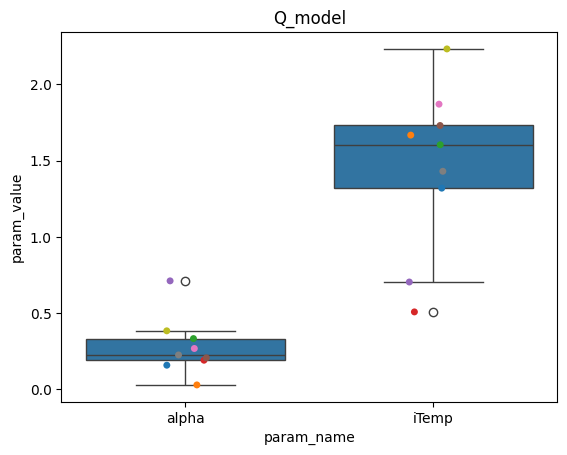

In [14]:
# Fit model seperately to each subject and plot parameter values.


def fit_subjects(sessions, model, MAP_fit=False, compute_CVLL=False, plot=False):
    """Fit sessions for each subject with a seperate set of parameter values, return subject fits
    as a dataframe, optionally plot fit."""
    # Fit sessions for each subject seperately.
    subjects = set([session.subject for session in sessions])
    subject_fits = []
    for subject in subjects:
        subject_sessions = [session for session in sessions if session.subject == subject]
        subject_fit = fit_sessions(subject_sessions, model, compute_CVLL=compute_CVLL, MAP_fit=MAP_fit)
        subject_fit["subject"] = subject
        subject_fits.append(subject_fit)

    # Generate subject fits dataframe.
    subject_fits_df = pd.DataFrame(
        {
            "subject": [fit["subject"] for fit in subject_fits],
            "model": [fit["model"] for fit in subject_fits],
            "log_likelihood": [fit["log_likelihood"] for fit in subject_fits],
            "AIC": [fit["AIC"] for fit in subject_fits],
            "BIC": [fit["BIC"] for fit in subject_fits],
            "CVLL": [fit["CVLL"] for fit in subject_fits],
            "n_trials": [fit["n_trials"] for fit in subject_fits],
            "n_free_choice_trials": [fit["n_free_choice_trials"] for fit in subject_fits],
        }
    )
    for i, param_name in enumerate(model.param_names):
        subject_fits_df[f"params.{param_name}"] = [fit["param_values"][i] for fit in subject_fits]

    # Plotting
    if plot:
        param_values_df = pd.melt(  # Convert to long format dataframe.
            subject_fits_df,
            id_vars=["subject"],
            value_vars=[col for col in subject_fits_df if col.startswith("params.")],
            var_name="param_name",
            value_name="param_value",
        )
        param_values_df.param_name = param_values_df.param_name.apply(lambda x: x.split(".")[1])
        plt.figure()
        sns.boxplot(param_values_df, x="param_name", y="param_value")
        sns.stripplot(param_values_df, x="param_name", y="param_value", hue="subject", legend=False)
        plt.title(model.name)
    return subject_fits_df


subject_fits = fit_subjects(sessions, q_model, MAP_fit=True, plot=True)
subject_fits

## Model comparision

Often we want to compare the goodness of fit for several different models and assess which provides the best account of the behavioural data.  We will first define some additonal models so we have multiple model to compare.

In [15]:
# Q model with perseveration.


class Q_model_prsv:
    """Version of Q_model with additonal perseveration parameter which promotes repeating the previous trials choice."""

    def __init__(self):
        self.name = "Q_model_prsv"
        self.param_names = ["alpha", "iTemp", "prsv"]
        self.param_ranges = ["unit", "pos", "pos"]
        self.n_params = 3

    def session_log_likelihood(self, session, param_values):
        """Return the data likelihood for the session given the provided parameter values."""

        # Get trial events.
        choices, outcomes, free_choice = get_trial_data(session)

        # Unpack parameters.
        alpha, iTemp, prsv = param_values

        # Variables.
        Q = np.zeros([2, session.n_trials])  # Q values for left and right choices.
        P = np.zeros([2, session.n_trials])  # Perseveration bounus for left and right choices.

        for i, (c, o) in enumerate(zip(choices[:-1], outcomes)):  # loop over trials.
            # Update action values.
            n = 1 - c  # Not chosen action.

            Q[n, i + 1] = Q[n, i]  # Not chosen action value is unchanged.
            Q[c, i + 1] = (1.0 - alpha) * Q[c, i] + alpha * o  # TD update.
            P[c, i + 1] = prsv

        # Compute data likelihood.
        choice_probs = softmax_probs(Q + P, iTemp)
        trial_log_likelihood = log_safe(choice_probs[choices, np.arange(len(choices))])
        session_log_likelihood = np.sum(trial_log_likelihood[free_choice])

        return session_log_likelihood


# Q model with bias.


class Q_model_bias:
    """Version of Q_model with additonal bias parameter which biases choices towards the left or right option."""

    def __init__(self):
        self.name = "Q_model_bias"
        self.param_names = ["alpha", "iTemp", "bias"]
        self.param_ranges = ["unit", "pos", "unc"]
        self.n_params = 3

    def session_log_likelihood(self, session, param_values):
        """Return the data likelihood for the session given the provided parameter values."""

        # Get trial events.
        choices, outcomes, free_choice = get_trial_data(session)

        # Unpack parameters.
        alpha, iTemp, bias = param_values

        # Variables.
        Q = np.zeros([2, session.n_trials])  # Q values for left and right choices.

        for i, (c, o) in enumerate(zip(choices[:-1], outcomes)):  # loop over trials.
            # Update action values.
            n = 1 - c  # Not chosen action.

            Q[n, i + 1] = Q[n, i]  # Not chosen action value is unchanged.
            Q[c, i + 1] = (1.0 - alpha) * Q[c, i] + alpha * o  # TD update.

        Q[0, :] = Q[0, :] + bias  # Apply bias

        # Compute data likelihood.
        choice_probs = softmax_probs(Q, iTemp)
        trial_log_likelihood = log_safe(choice_probs[choices, np.arange(len(choices))])
        session_log_likelihood = np.sum(trial_log_likelihood[free_choice])

        return session_log_likelihood


# Q model with forgetting


class Q_model_forget:
    """Modified version of Q_model which incorporates forgetting about value of not chosen option implemented
    as decay towards neutral value of 0.5 with forgetting rate parameter alp_f."""

    def __init__(self):
        self.name = "Q_model_forget"
        self.param_names = ["alpha", "iTemp", "alp_f"]
        self.param_ranges = ["unit", "pos", "unit"]
        self.n_params = 3

    def session_log_likelihood(self, session, param_values):
        """Return the data likelihood for the session given the provided parameter values."""

        # Get trial events.
        choices, outcomes, free_choice = get_trial_data(session)

        # Unpack parameters.
        alpha, iTemp, alp_f = param_values

        # Variables.
        Q = np.zeros([2, session.n_trials])  # Q values for left and right choices.

        for i, (c, o) in enumerate(zip(choices[:-1], outcomes)):  # loop over trials.
            # Update action values.
            n = 1 - c  # Not chosen action.

            Q[n, i + 1] = (1.0 - alp_f) * Q[n, i] + alp_f * 0.5  # Not chosen action value decays towards 0.5
            Q[c, i + 1] = (1.0 - alpha) * Q[c, i] + alpha * o  # TD update.

        # Compute data likelihood.
        choice_probs = softmax_probs(Q, iTemp)
        trial_log_likelihood = log_safe(choice_probs[choices, np.arange(len(choices))])
        session_log_likelihood = np.sum(trial_log_likelihood[free_choice])

        return session_log_likelihood

We will now instantiate an instance of each model and fit it to each subjects data.

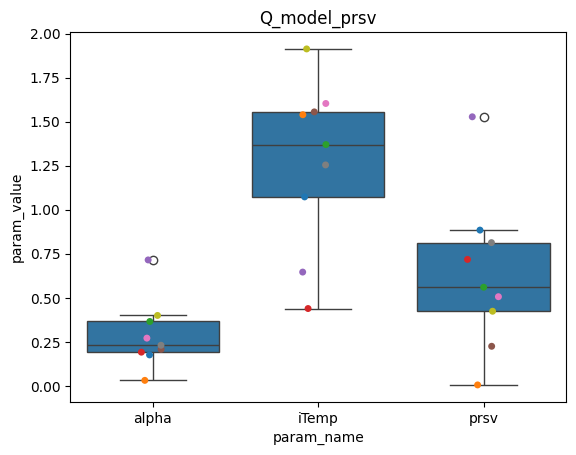

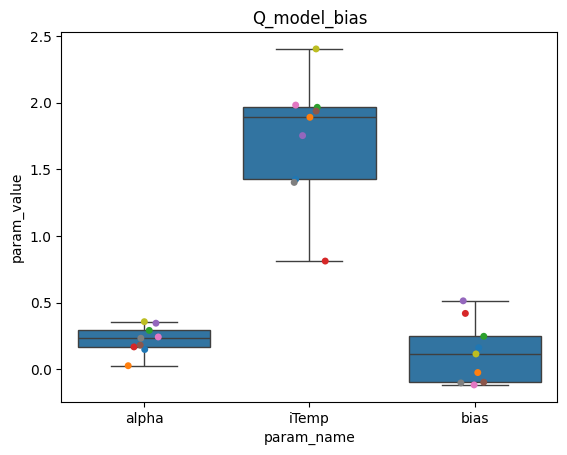

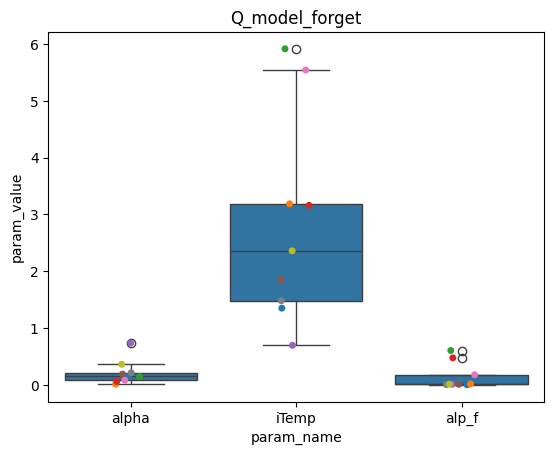

In [16]:
# Instantiate models.

q_model_prsv = Q_model_prsv()
q_model_bias = Q_model_bias()
q_model_forget = Q_model_forget()

# Do per-subject fits for all models.
subject_fits_prsv = fit_subjects(sessions, q_model_prsv, MAP_fit=True, plot=True)
subject_fits_bias = fit_subjects(sessions, q_model_bias, MAP_fit=True, plot=True)
subject_fits_forget = fit_subjects(sessions, q_model_forget, MAP_fit=True, plot=True)

model_fits = [subject_fits, subject_fits_prsv, subject_fits_bias, subject_fits_forget]

We are now ready to compare the goodness of fit of the different models.  To do this we need to choose goodness-of-fit metric, and a method for testing whether observed differences in this metric between models are statistically significant.  

The data log likelihood is a metric of goodness-of-fit, because it indicates how closely the model's choice behaviour conforms to that of the subjects.  Indeed, most widely used measures of goodness-of-fit utilise the data likelihood.  However, the data likelihood obtained after optimising the model paramters to best fit the data cannot be used directly to compare models with different numbers of parameters, due to [overfitting](https://en.wikipedia.org/wiki/Overfitting).  A model with more parameters my fit the data better than a model with fewer parameters even if the additional parameters do not cature real features of behaviour that generated the data, due to overfitting to noise (i.e. random variability) in the data used to fit the model. There are two commonly used methods to avoid this issue when doing model comparison: 
1) Use a metric which combines the data likelihood with annother term which penalises models with more parameters.  Two commonly used metrics which do this are the [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC) and [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC).  These two metrics differ in how much they penalise a model for having more parameters, and a discussion of their relative merits is beyond the scope of this notebook. You may have noticed that the model fitting code above calculates both of these metrics and saves them in the fit summary.
2) Use [cross-validated](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) log likelihood (CVLL), i.e. the data likelihood obtained when the model is evaluated on test data that was not used to fit the parameters.  Typically this is done by repeatedly splitting the available data into a large training set and small test set, using a different portion of the data as the test set on each repeat (termed a "fold"), such that all the data is used both in the test set and training set across different folds.  You may have noticed that the `fit_sessions` and `fit_subjects` functions above had an argument `compute_CVLL` which allows for computing the CVLL using a function defined later in the notebook.  We have not used this option when computing fits above because it adds a lot of compute time due to running the model fitting many times for different test/train splits of the data, but see below for how to use it.

Having selected a goodness-of-fit metric (AIC, BIC or cross-validated log likelihood), we need to decide how we will evaluate whether differences in this metric between models are significant.  Here we will consider the situation where we have data from a set of different subjects, and we want to know which models are a significantly less good fit than the best model, taking into account possible differences between subjects in how how well each model fits their choices.  To do this we will rank the models according to their average goodness-of-fit metric across subjects, and then test each model against the best fitting model using a paired test with subject as the experimental unit.  A slight complication is that the the size of differences in the goodness-of-fit metric between models will depend not just on how well the models fit the data, but also the amount of data that goes into the fits.  This is because the log likelihood is summed over trials, so the more trials there are in the data, the larger the difference in log likelihood (and hence also in BIC and AIC score which depend on likelihood) for a given underlying difference in goodness-of-fit.  It can therefore be useful to normalise the goodness-of-fit metric for each subject by the number of trials in that subject's data.  Note that this normalisation does not change the rank ordering of goodness-of-fit within subject.  Alternatively one can use a non-parametric test which only depends on the rank ordering within subject but not the absolute value of differences in metric between models.

,BIC,P value
model,,
Q_model_prsv,1621.320017,NaN
Q_model_bias,1738.781673,0.003935
Q_model,1765.119150,0.002188
Q_model_forget,1771.412832,0.001911


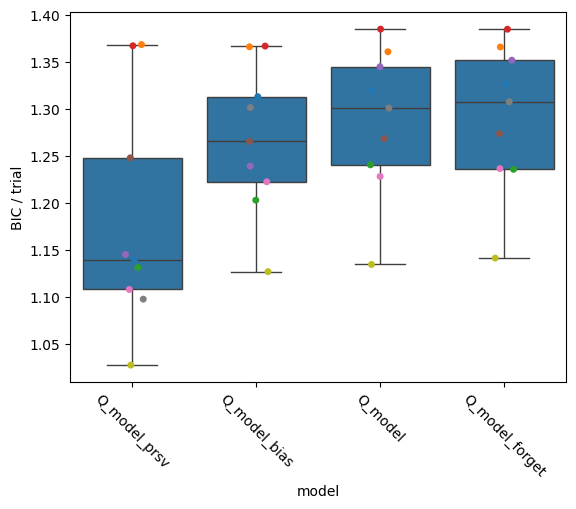

In [17]:
def model_comparison(model_fits, metric="BIC", parametric=True, normalise=True):
    """Compare a set of subject_fits using specified metric and test whether each model is significantly
    less well fitting than the best model using cross subject variability.
    Arguments:
    model_fits: A list of model fits obtained by using the fit_subjects function on the same data.
    metric: The goodness-of-fit metric to use for comparison.
    parametric: Whether to use a parametric or non-parametric statistical test.
    normalise: Whether to normalise the metric by the number of choice for each subject.
    """
    assert metric in ("BIC", "AIC", "CVLL"), "Invalid metric."
    if metric in ("BIC", "AIC"):  # Low values are best.
        sort_ascending = True
        test_side = "greater"
    elif metric == "CVLL":  # High values are best.
        sort_ascending = False
        test_side = "less"
    fits_df = pd.concat(model_fits, axis=0)
    fits_df["metric"] = fits_df[metric]
    if normalise:
        fits_df["metric"] = fits_df["metric"] / fits_df["n_free_choice_trials"]
    model_means = fits_df.groupby("model").mean(numeric_only=True).sort_values("metric", ascending=sort_ascending)
    model_order = model_means.index.to_list()  # Best to worst.
    # Compute P values for difference relative to best model using cross subject variability.
    best_model_metric = fits_df.loc[fits_df.model == model_order[0], :].sort_values("subject")["metric"]
    for alt_model in model_order[1:]:
        alt_model_metric = fits_df.loc[fits_df.model == alt_model, :].sort_values("subject")["metric"]
        if parametric:
            p_value = ttest_rel(alt_model_metric, best_model_metric, alternative=test_side).pvalue
        else:
            p_value = wilcoxon(alt_model_metric - best_model_metric, alternative=test_side).pvalue
        model_means.loc[alt_model, "P value"] = p_value
    p_value_df = model_means.loc[:, (metric, "P value")]
    # Plotting
    plt.figure()
    sns.boxplot(x="model", y="metric", data=fits_df, order=model_order)
    ax = sns.stripplot(x="model", y="metric", data=fits_df, order=model_order, hue="subject", legend=False)
    ax.tick_params(axis="x", labelrotation=-45)
    plt.ylabel(f"{metric} / trial" if normalise else metric)
    return p_value_df


model_comparison(model_fits)

To use cross-validated log likelihood for model comparison we would need to add this metric to our per-subject model fits.  Here we will compute the cross validated log likelihood using 'leave-one-out' test/train splits, where on each fold one session is held out from the training data and used as the test data to evaluate the cross-validated likelihood.  This approach means that the number of folds (and hence number of times the model fitting is run) is equal to the number of sessions, which is reasonable when the number of sessions per subject is small (e.g. <=10) but will result in long compute time if the number of sessions is large.  In this case, k-fold cross validation, i.e. splitting the data into k seperate folds where k is e.g. 10, may be more suitable.

In [18]:
def cross_validated_log_likelihood(sessions, model, MAP_fit=False):
    """Compute cross validated log likelihood using leave-one-session-out cross validation."""
    fold_log_likelihoods = []
    for test_session in sessions:
        train_sessions = [session for session in sessions if session is not test_session]
        train_fit = fit_sessions(train_sessions, model, MAP_fit=MAP_fit)
        fold_log_likelihoods.append(model.session_log_likelihood(test_session, train_fit["param_values"]))
    return sum(fold_log_likelihoods)


cross_validated_log_likelihood(subject_sessions, q_model)

-883.8255309805093

The cell below reruns the subject fits, now computing the cross-validated log-likelihood, then runs the model comparison using CVLL as the metric.  The code is commented out as computing the cross validated log-likelihood is slow.

In [19]:
# models = [q_model, q_model_prsv, q_model_bias, q_model_forget]
# model_fits = [fit_subjects(sessions, model, MAP_fit=True, compute_CVLL=True, plot=False) for model in models]
# model_comparison(model_fits, metric="CVLL")

## Configurable model class.

Often we want to try different combinations of model features when comparing models, for example whether including perseveration, bias, and/or forgetting improves goodness of fit.  Rather than implementing seperate model classes for every combination, it can be convinient to define a model class which can be configured to include different features when it is instantiated.

Additionally, in the class below we have added an optional argument to the session_log_likelihood function which causes it to return the Q values.  This is useful if you want to use the Q values in annother analysis, e.g. as a predictor to explain neural data.

In [20]:
class Q_model_config:
    """Configurable version of Q_model class with optional perseveration, bias and forgetting parameters."""

    def __init__(self, bias=False, prsv=False, forget=False):
        self.name = "Q_model"
        self.bias = bias
        self.prsv = prsv
        self.forget = forget
        self.param_names = ["alpha", "iTemp"]
        self.param_ranges = ["unit", "pos"]
        # Add optional parameters.
        if self.bias:
            self.name += "_bias"
            self.param_names += ["bias"]
            self.param_ranges += ["unc"]
        if self.prsv:
            self.name += "_prsv"
            self.param_names += ["prsv"]
            self.param_ranges += ["pos"]
        if self.forget:
            self.name += "_forget"
            self.param_names += ["alp_f"]
            self.param_ranges += ["unit"]
        self.n_params = len(self.param_names)

    def session_log_likelihood(self, session, param_values, return_Q_values=False):
        """Return the data likelihood for the session given the provided parameter values."""

        # Get trial events.
        choices, outcomes, free_choice = get_trial_data(session)

        # Make object for accessing parameter values by name.
        pv = SimpleNamespace(**dict(zip(self.param_names, param_values)))

        # Variables.
        Q = np.zeros([2, session.n_trials])  # Q values for left and right choices.
        P = np.zeros([2, session.n_trials])  # Perseveration bounus for left and right choices.

        for i, (c, o) in enumerate(zip(choices[:-1], outcomes)):  # loop over trials.
            # Update action values.
            n = 1 - c  # Not chosen action.

            if self.forget:
                Q[n, i + 1] = (1.0 - pv.alp_f) * Q[n, i] + pv.alp_f * 0.5  # Not chosen action value decays towards 0.5
            else:
                Q[n, i + 1] = Q[n, i]  # Not chosen action value is unchanged.

            Q[c, i + 1] = (1.0 - pv.alpha) * Q[c, i] + pv.alpha * o  # TD update.

            if self.prsv:
                P[c, i + 1] = pv.prsv

        if self.bias:
            Q[0, :] = Q[0, :] + pv.bias  # Apply bias

        # Compute data likelihood.
        choice_probs = softmax_probs(Q + P, pv.iTemp)
        trial_log_likelihood = log_safe(choice_probs[choices, np.arange(len(choices))])
        session_log_likelihood = np.sum(trial_log_likelihood[free_choice])

        if return_Q_values:
            return Q
        else:
            return session_log_likelihood

We will now instantiate a set of different model variants and do model comparison with them.

,BIC,P value
model,,
Q_model_bias_prsv,1606.601893,NaN
Q_model_bias_prsv_forget,1612.369566,0.001758
Q_model_prsv,1621.320017,0.064639
Q_model_prsv_forget,1625.539401,0.027736
Q_model_bias,1738.781673,0.002323
Q_model,1765.119150,0.002308
Q_model_forget,1771.412832,0.002001


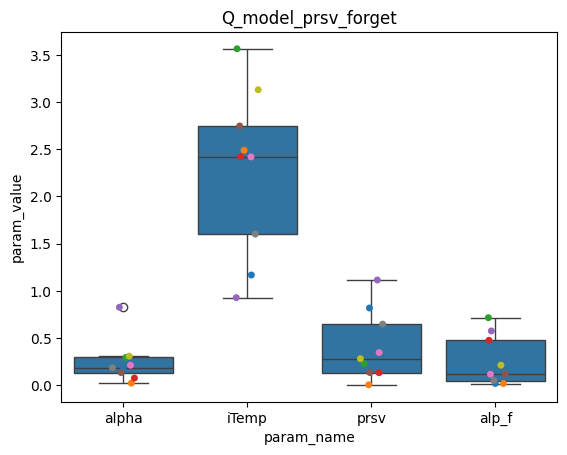

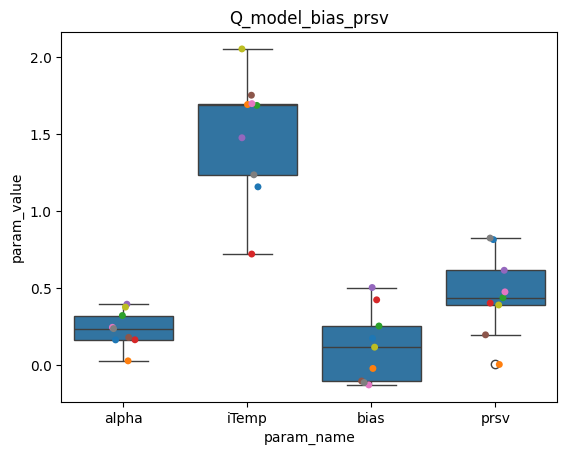

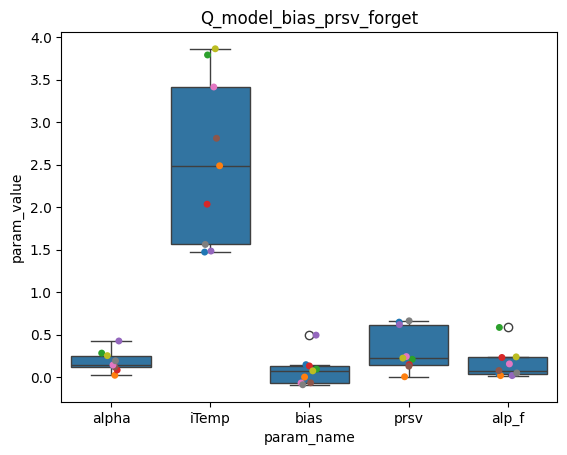

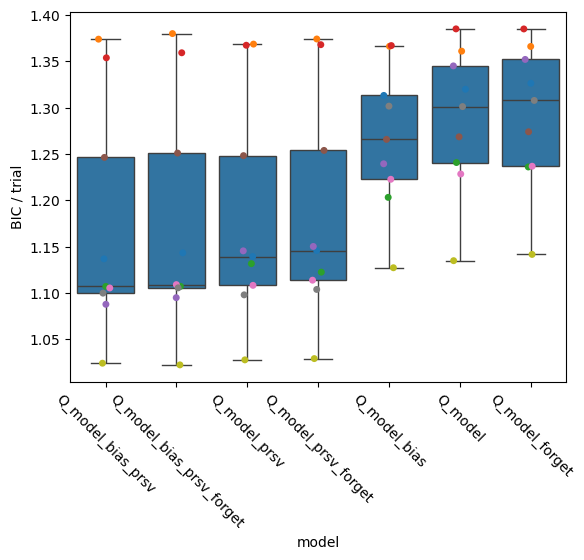

In [21]:
new_models = [
    Q_model_config(bias=False, prsv=True, forget=True),
    Q_model_config(bias=True, prsv=True, forget=False),
    Q_model_config(bias=True, prsv=True, forget=True),
]

new_model_fits = [fit_subjects(sessions, model, MAP_fit=True, plot=True) for model in new_models]

model_comparison(model_fits + new_model_fits)

(c) Thomas Akam 2025, released under the GPL3 licence.